In [ ]:
!pip install youtube-transcript-api googletrans==4.0.0-rc1


In [9]:
#!/usr/bin/env python3
"""
yt_transcript_df.py

Fetch a YouTube transcript, translate it into Armenian,
and return/save the result as a pandas DataFrame.
"""

import re
import sys

import pandas as pd
from youtube_transcript_api import (
    YouTubeTranscriptApi,
    TranscriptsDisabled,
    NoTranscriptFound,
)
from googletrans import Translator

def extract_video_id(url: str) -> str:
    """
    Extract the YouTube video ID from various URL formats.
    """
    print("Extracting video ID from URL...")
    patterns = [
        r"(?:v=|/videos/|youtu\.be/|embed/)([A-Za-z0-9_-]{11})",
    ]
    for pat in patterns:
        m = re.search(pat, url)
        if m:
            video_id = m.group(1)
            print(f" → Video ID is {video_id}")
            return video_id
    raise ValueError(f"Could not extract video ID from URL: {url}")

def fetch_transcript(video_id: str, languages=None):
    """
    Fetch the transcript for the given video ID.
    Tries in order of the provided `languages` list.
    """
    if languages is None:
        languages = ['en', 'auto']
    print(f"Fetching transcript for video ID: {video_id}...")
    try:
        transcript_list = YouTubeTranscriptApi.list_transcripts(video_id)
        for lang in languages:
            try:
                transcript = transcript_list.find_transcript([lang]).fetch()
                print(f" → Found transcript in '{lang}'")
                return transcript
            except Exception:
                continue
        # fallback
        transcript = transcript_list.fetch()
        print(" → Found transcript in a fallback language")
        return transcript
    except TranscriptsDisabled:
        sys.exit("Error: Transcripts are disabled for this video.")
    except NoTranscriptFound:
        sys.exit("Error: No transcript found for this video.")
    except Exception as e:
        sys.exit(f"Error fetching transcript: {e}")

def get_translated_transcript_df(
    url: str,
    dest_language: str = 'hy',
    save_path: str = 'translated_transcript.csv'
) -> pd.DataFrame:
    """
    Given a YouTube URL, fetch + translate into `dest_language`,
    return a DataFrame and save it to CSV.
    """
    vid = extract_video_id(url)
    segments = fetch_transcript(vid)
    translator = Translator()
    rows = []

    print("Translating segments into Armenian…")
    for i, seg in enumerate(segments, start=1):
        # direct attribute access
        start = seg.start
        text = seg.text

        minutes = int(start // 60)
        seconds = start % 60
        timestamp = f"{minutes:02d}:{seconds:05.2f}"

        translation = translator.translate(text, dest=dest_language).text

        rows.append({
            'timestamp': timestamp,
            'original': text,
            'translation': translation,
        })

        if i % 20 == 0:
            print(f"  …translated {i} segments")

    df = pd.DataFrame(rows, columns=['timestamp', 'original', 'translation'])
    print(f"Translated {len(df)} total segments.")

    # save to CSV
    df.to_csv(save_path, index=False, encoding='utf-8-sig')
    print(f"Saved DataFrame to '{save_path}'.")

    return df

if __name__ == "__main__":
    try:
        url = input("Enter YouTube video URL: ").strip()
        df = get_translated_transcript_df(url)
        print("\nFirst 5 rows of the translated transcript:")
        print(df.head().to_string(index=False))
    except Exception as e:
        print(f"Error: {e}")


Extracting video ID from URL...
 → Video ID is 98TQv5IAtY8
Fetching transcript for video ID: 98TQv5IAtY8...
 → Found transcript in 'en'
Translating segments into Armenian…
  …translated 20 segments
  …translated 40 segments
  …translated 60 segments
Translated 76 total segments.
Saved DataFrame to 'translated_transcript.csv'.

First 5 rows of the translated transcript:
timestamp                                                         original                                                                    translation
 00:06.63                              Imagine an island where 100 people,                                         Պատկերացրեք մի կղզի, որտեղ 100 մարդ է,
 00:09.07        all perfect logicians,\nare imprisoned by a mad dictator.     Բոլոր կատարյալ տեղեկամատյանները,\nբանտարկվում են խելագար դիկտատորի կողմից:
 00:14.15                 There's no escape,\nexcept for one strange rule.                           Փախուստ չկա,\nբացառությամբ մեկ տարօրինակ կառավարման:
 00:18.29 An

In [10]:
df

,timestamp,original,translation
0,00:06.63,"Imagine an island where 100 people,","Պատկերացրեք մի կղզի, որտեղ 100 մարդ է,"
1,00:09.07,"all perfect logicians,\nare imprisoned by a ma...","Բոլոր կատարյալ տեղեկամատյանները,\nբանտարկվում ..."
2,00:14.15,"There's no escape,\nexcept for one strange rule.","Փախուստ չկա,\nբացառությամբ մեկ տարօրինակ կառավ..."
3,00:18.29,Any prisoner can approach the guards\nat night...,Prany անկացած բանտարկյալ կարող է մոտենալ պահակ...
4,00:23.05,"If they have green eyes, \nthey'll be released.","Եթե ​​նրանք ունեն կանաչ աչքեր,\nՆրանք կազատվեն:"
...,...,...,...
71,04:04.32,the others are keeping track of,մյուսները հետեւում են
72,04:06.43,until as many nights have passed\nas the numbe...,Մինչեւ շատ գիշերներ են անցել\nորպես կղզու բանտ...
73,04:12.57,"Of course, you could have spared\nthe prisoner...","Իհարկե, դուք կարող եք խնայել\nԲանտարկյալները կ..."
74,04:17.10,by telling them at least 99 of you\nhave green...,նրանց պատմելով ձեզանից առնվազն 99-ը\nունեն կան...


In [4]:
!python yt_translate.py "https://www.youtube.com/watch?v=98TQv5IAtY8" -o transcript_en.txt


python: can't open file 'c:\\Users\\hayk_\\OneDrive\\Desktop\\python_math_ml_course\\python\\mini_projects\\yt_transcript_translator\\yt_translate.py': [Errno 2] No such file or directory


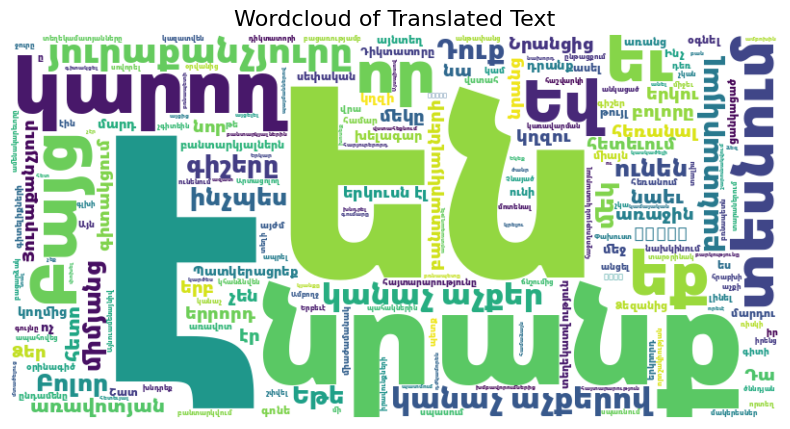

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(text, font_path=None):
    """
    Generate and display a wordcloud from the given text.
    """
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        font_path=font_path,  # Specify Armenian font path if needed
        colormap="viridis"
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Wordcloud of Translated Text", fontsize=16)
    plt.show()

# Example usage
if 'translation' in df.columns:
    all_translations = " ".join(df['translation'])
    generate_wordcloud(all_translations,
                       "NotoSansArmenian-Black.ttf")  # Update font path if necessary
else:
    print("No 'translation' column found in DataFrame.")

In [ ]:
!